In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!pip install openl3

In [3]:
import openl3
from keras import Model, Input

import librosa
import numpy as np

Using TensorFlow backend.


In [ ]:
model = openl3.models.load_audio_embedding_model(input_repr="mel128", content_type="env", embedding_size=6144)

In [5]:
inp = model.get_layer('input_1').input
oups = [
    model.get_layer('melspectrogram_1').output,
    model.get_layer('batch_normalization_1').output,
    model.get_layer('conv2d_1').output,
    model.get_layer('batch_normalization_2').output,
    model.get_layer('activation_1').output,
    model.get_layer('conv2d_2').output,
    model.get_layer('batch_normalization_3').output,
    model.get_layer('activation_2').output,
    model.get_layer('conv2d_3').output,
    model.get_layer('batch_normalization_4').output,
    model.get_layer('batch_normalization_8').output,
    model.get_layer('activation_7').output,
    model.get_layer('audio_embedding_layer').output,
    model.get_layer('max_pooling2d_4').output,
    model.get_layer('flatten_1').output,
]

model2 = Model(inputs=[inp], outputs=oups)

In [6]:
audio_np, sr = librosa.load(
        '/content/drive/MyDrive/Audiomodel/sampleaudio.623702.ogg',
        sr=48000) 

In [7]:
TARGET_SR = 48000
hop_size=0.1
hop_len = int(hop_size * TARGET_SR)
frame_len = TARGET_SR
def _pad_audio(audio, frame_len, hop_len):
    """Pad audio if necessary so that all samples are processed"""
    audio_len = audio.size
    if audio_len < frame_len:
        pad_length = frame_len - audio_len
    else:
        pad_length = int(np.ceil((audio_len - frame_len)/float(hop_len))) * hop_len \
                     - (audio_len - frame_len)

    if pad_length > 0:
        audio = np.pad(audio, (0, pad_length), mode='constant', constant_values=0)

    return audio

audio = _pad_audio(audio_np, frame_len, hop_len)

n_frames = 1 + int((len(audio) - frame_len) / float(hop_len))
x = np.lib.stride_tricks.as_strided(audio, shape=(frame_len, n_frames),
        strides=(audio.itemsize, hop_len * audio.itemsize)).T
x = x.reshape((x.shape[0], 1, x.shape[-1]))
print(x.shape)

(32, 1, 48000)


In [8]:
tensorflow_ouputs = model2.predict(x, verbose=True)

32/32 [==============================] - 11s 347ms/step


In [9]:
mel_spec_output = tensorflow_ouputs[0]

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [11]:
def load_weights(weight_file):
    if weight_file == None:
        return

    try:
        weights_dict = np.load(weight_file,allow_pickle=True).item()
    except:
        weights_dict = np.load(weight_file, encoding='bytes',allow_pickle=True).item()

    return weights_dict

In [14]:
class PytorchOpenl3(nn.Module):

    
    def __init__(self, weight_file):
        super(PytorchOpenl3, self).__init__()
        self.__weights_dict = load_weights(weight_file)

        self.batch_normalization_1 = self.__batch_normalization(2, 'batch_normalization_1', num_features=1, eps=0.001, momentum=0.99)
        self.conv2d_1 = self.__conv(2, name='conv2d_1', in_channels=1, out_channels=64, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.batch_normalization_2 = self.__batch_normalization(2, 'batch_normalization_2', num_features=64, eps=0.001, momentum=0.99)
        self.conv2d_2 = self.__conv(2, name='conv2d_2', in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.batch_normalization_3 = self.__batch_normalization(2, 'batch_normalization_3', num_features=64, eps=0.001, momentum=0.99)
        self.conv2d_3 = self.__conv(2, name='conv2d_3', in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.batch_normalization_4 = self.__batch_normalization(2, 'batch_normalization_4', num_features=128, eps=0.001, momentum=0.99)
        self.conv2d_4 = self.__conv(2, name='conv2d_4', in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.batch_normalization_5 = self.__batch_normalization(2, 'batch_normalization_5', num_features=128, eps=0.001, momentum=0.99)
        self.conv2d_5 = self.__conv(2, name='conv2d_5', in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.batch_normalization_6 = self.__batch_normalization(2, 'batch_normalization_6', num_features=256, eps=0.001, momentum=0.99)
        self.conv2d_6 = self.__conv(2, name='conv2d_6', in_channels=256, out_channels=256, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.batch_normalization_7 = self.__batch_normalization(2, 'batch_normalization_7', num_features=256, eps=0.001, momentum=0.99)
        self.conv2d_7 = self.__conv(2, name='conv2d_7', in_channels=256, out_channels=512, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.batch_normalization_8 = self.__batch_normalization(2, 'batch_normalization_8', num_features=512, eps=0.001, momentum=0.99)
        self.audio_embedding_layer = self.__conv(2, name='audio_embedding_layer', in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)

    def forward(self, x):
        batch_normalization_1 = self.batch_normalization_1(x)
        conv2d_1_pad    = F.pad(batch_normalization_1, (1, 1, 1, 1))
        conv2d_1        = self.conv2d_1(conv2d_1_pad)
        batch_normalization_2 = self.batch_normalization_2(conv2d_1)
        activation_1    = F.relu(batch_normalization_2)
        conv2d_2_pad    = F.pad(activation_1, (1, 1, 1, 1))
        conv2d_2        = self.conv2d_2(conv2d_2_pad)
        batch_normalization_3 = self.batch_normalization_3(conv2d_2)
        activation_2    = F.relu(batch_normalization_3)
        max_pooling2d_1 = F.max_pool2d(activation_2, kernel_size=(2, 2), stride=(2, 2), padding=0, ceil_mode=False)
        conv2d_3_pad    = F.pad(max_pooling2d_1, (1, 1, 1, 1))
        conv2d_3        = self.conv2d_3(conv2d_3_pad)
        batch_normalization_4 = self.batch_normalization_4(conv2d_3)
        activation_3    = F.relu(batch_normalization_4)
        conv2d_4_pad    = F.pad(activation_3, (1, 1, 1, 1))
        conv2d_4        = self.conv2d_4(conv2d_4_pad)
        batch_normalization_5 = self.batch_normalization_5(conv2d_4)
        activation_4    = F.relu(batch_normalization_5)
        max_pooling2d_2 = F.max_pool2d(activation_4, kernel_size=(2, 2), stride=(2, 2), padding=0, ceil_mode=False)
        conv2d_5_pad    = F.pad(max_pooling2d_2, (1, 1, 1, 1))
        conv2d_5        = self.conv2d_5(conv2d_5_pad)
        batch_normalization_6 = self.batch_normalization_6(conv2d_5)
        activation_5    = F.relu(batch_normalization_6)
        conv2d_6_pad    = F.pad(activation_5, (1, 1, 1, 1))
        conv2d_6        = self.conv2d_6(conv2d_6_pad)
        batch_normalization_7 = self.batch_normalization_7(conv2d_6)
        activation_6    = F.relu(batch_normalization_7)
        max_pooling2d_3 = F.max_pool2d(activation_6, kernel_size=(2, 2), stride=(2, 2), padding=0, ceil_mode=False)
        conv2d_7_pad    = F.pad(max_pooling2d_3, (1, 1, 1, 1))
        conv2d_7        = self.conv2d_7(conv2d_7_pad)
        batch_normalization_8 = self.batch_normalization_8(conv2d_7)
        activation_7    = F.relu(batch_normalization_8)
        audio_embedding_layer_pad = F.pad(activation_7, (1, 1, 1, 1))
        audio_embedding_layer = self.audio_embedding_layer(audio_embedding_layer_pad)
        max_pooling2d_4 = F.max_pool2d(audio_embedding_layer, kernel_size=(4, 8), stride=(4, 8), padding=0, ceil_mode=False)
        return max_pooling2d_4


    def __batch_normalization(self, dim, name, **kwargs):
        if   dim == 0 or dim == 1:  layer = nn.BatchNorm1d(**kwargs)
        elif dim == 2:  layer = nn.BatchNorm2d(**kwargs)
        elif dim == 3:  layer = nn.BatchNorm3d(**kwargs)
        else:           raise NotImplementedError()

        if 'scale' in self.__weights_dict[name]:
            layer.state_dict()['weight'].copy_(torch.from_numpy(self.__weights_dict[name]['scale']))
        else:
            layer.weight.data.fill_(1)

        if 'bias' in self.__weights_dict[name]:
            layer.state_dict()['bias'].copy_(torch.from_numpy(self.__weights_dict[name]['bias']))
        else:
            layer.bias.data.fill_(0)

        layer.state_dict()['running_mean'].copy_(torch.from_numpy(self.__weights_dict[name]['mean']))
        layer.state_dict()['running_var'].copy_(torch.from_numpy(self.__weights_dict[name]['var']))
        return layer

    def __conv(self, dim, name, **kwargs):
        if   dim == 1:  layer = nn.Conv1d(**kwargs)
        elif dim == 2:  layer = nn.Conv2d(**kwargs)
        elif dim == 3:  layer = nn.Conv3d(**kwargs)
        else:           raise NotImplementedError()

        layer.state_dict()['weight'].copy_(torch.from_numpy(self.__weights_dict[name]['weights']))
        if 'bias' in self.__weights_dict[name]:
            layer.state_dict()['bias'].copy_(torch.from_numpy(self.__weights_dict[name]['bias']))
        return layer

In [15]:
model = PytorchOpenl3('/content/drive/MyDrive/Audiomodel/openl3_no_mel_layer_pytorch_weights')

In [16]:
with torch.set_grad_enabled(False):
    model = model.eval()
    pytorch_output = model(
        torch.Tensor(mel_spec_output.swapaxes(2, 3).swapaxes(1, 2))
    )
    pytorch_output = pytorch_output.detach().numpy()

In [18]:
tensorflow_ouput = tensorflow_ouputs[-2].swapaxes(2, 3).swapaxes(1, 2)

In [19]:
tensorflow_ouput.shape,pytorch_output.shape

((32, 512, 4, 3), (32, 512, 4, 3))

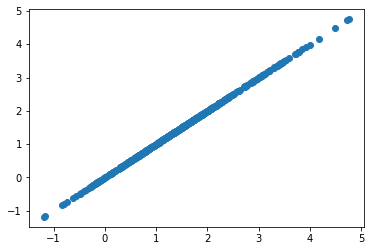

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(tensorflow_ouput[0, :, 0, 0], pytorch_output[0, :, 0, 0])

In [21]:
np.mean(np.abs(tensorflow_ouput.reshape(32,-1) - pytorch_output.reshape(32,-1)))

5.2225636e-07